# <center> Прототип решения по Треку 3:</center> <center> «Предсказание вероятности возникновения ДТП»</center>

## Постановка задачи

Разработать алгоритм прогнозирующий наиболее вероятную категорию события дорожно-транспортного происшествия (далее по тексту «ДТП»):

>1. ДТП не произойдет
>1. ДТП произойдет без пострадавших
>1. ДТП произойдет с пострадавшими

Данные для обучения — информация о ДТП от ГИБДД и ВНИИ ГОЧС, а также дополнительные данные по интенсивности движения, метеоусловиях на участках дороги и др. В качестве федеральных автомобильных дорог рассматриваются М-8 «Холмогоры» и Р-21 «Кола».

## Прототип решения

In [84]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
import functools
from geopy.distance import geodesic
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np

In [85]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### 1. Подготовка датасета для обучения модели

In [97]:
df = pd.read_pickle('data/train.pickle')
df = df.sort_values('datetime', ascending=True)
df.reset_index(drop=True, inplace=True)
df.head(2)

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target
0,2012-01-01 12:00:00,14,1276,1,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,33.319,68.212,gochs,2
1,2012-01-01 22:00:00,9,278,2,0,3.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",0.000,0.000,gochs,2


#### Тренеровочный датасет (`train.csv`):
> 1. **datetime** - дата события в формате `yyyy-MM-dd hh-mm-ss`
> 1. **road_id** - код автодороги, принимает одно из трех значений:
>    * 5 — М-4 (E115) “Дон” Москва - Новороссийск;
>    * 9 — М-8 (E115) “Холмогоры” Москва - Архангельск через Ярославль, Вологду;
>    * 4 — М-18 / Р-21 (E105) “Кола” С.Петербург - Мурманск через Петрозаводск.
> 1. **road_km** - км участка на котором произошло ДТП
> 1. **data_source** - источник данных события. В датасете атрибут принимает одно из двух значений:
>    * gibdd - ГИБДД;
>    * gochs - МЧС.
> 1. **target** - целевой признак является ли событие ДТП. В датасете атрибут принимает одно из четырех значений:
>    * 1 - ДТП без пострадавших;
>    * 2 - ДТП с пострадавшими;
>    * 3 - ЧС (объявляется от 5 погибших и/или 10 пострадавших)* в тестовой выборке события отсутствуют0 - событие не является ДТП;

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109737 entries, 0 to 109736
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         109737 non-null  datetime64[ns]
 1   road_id          109737 non-null  int64         
 2   road_km          109737 non-null  int64         
 3   man_injured_num  109737 non-null  int64         
 4   man_dead_num     109737 non-null  int64         
 5   car_damaged_num  102000 non-null  float64       
 6   road_name        109737 non-null  object        
 7   lon              55450 non-null   float64       
 8   lat              55450 non-null   float64       
 9   data_source      109737 non-null  object        
 10  target           109737 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 9.2+ MB


In [261]:
df.road_id.value_counts()

5     50030
9     23860
14    12742
Name: road_id, dtype: int64

In [99]:
start = df.datetime.min()
end = df.datetime.max()
print("Временной интервал наблюдений: от {} до {}".format(start,end))
gibdd = df.groupby('data_source')['road_id'].count()[0]
mchs = df.groupby('data_source')['road_id'].count()[1]
print("Кол-во наблюдений по источникам данных: ГИБДД - {}, МЧС {}".format(gibdd,mchs))

Временной интервал наблюдений: от 2012-01-01 12:00:00 до 2021-04-05 11:00:00
Кол-во наблюдений по источникам данных: ГИБДД - 94678, МЧС 15059


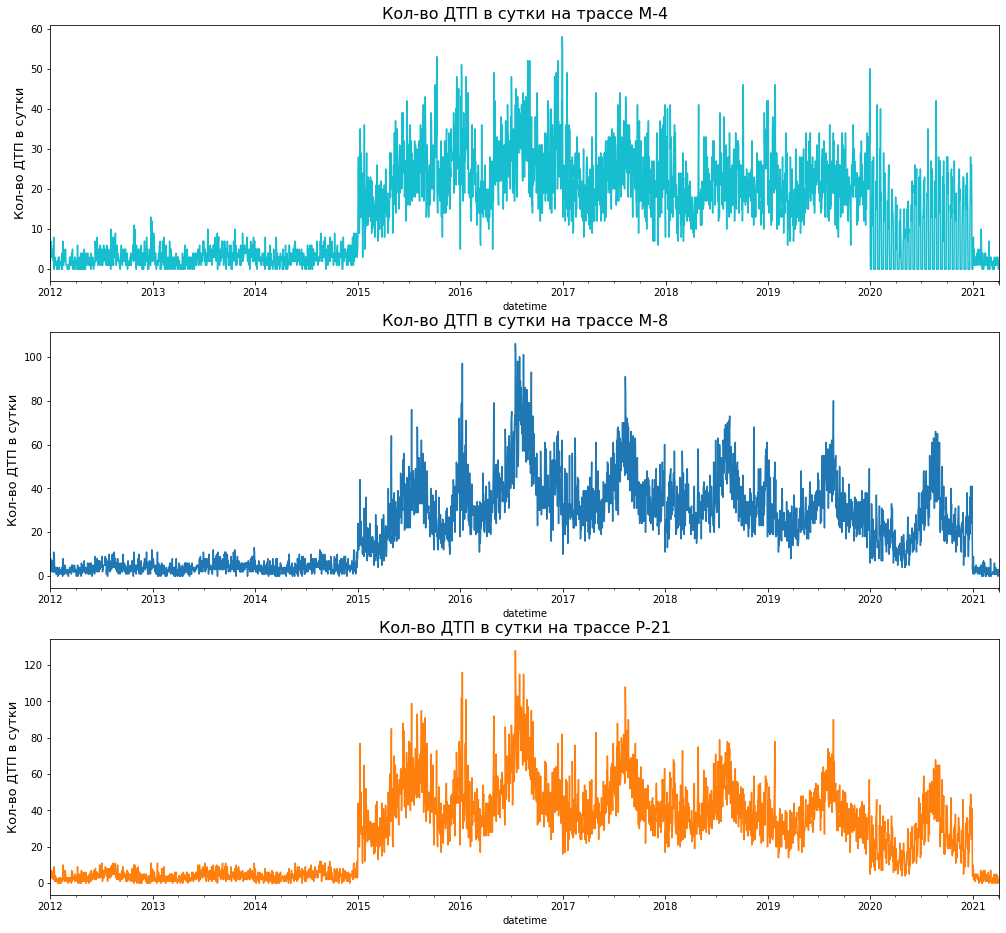

In [100]:
# распределение ДТП в расрезе трех трасс
fig, ax = plt.subplots(figsize=(17,16), ncols=1, nrows=3)

road_5 = df.drop(df[df["road_id"]==5].index)
road_9 = df.drop(df[df["road_id"]==9].index)
road_14 = df.drop(df[df["road_id"]==14].index)

dtp_day_5 = road_5[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_9 = road_9[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_14 = road_14[['datetime', 'target']].set_index('datetime').resample('D').count()['target']

dtp_day_5.plot(color='tab:cyan', ax=ax[0]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_9.plot(color='tab:blue', ax=ax[1]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_14.plot(color='tab:orange', ax=ax[2]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)

ax[0].set_title('Кол-во ДТП в сутки на трассе М-4',loc='center', fontsize=16)
ax[1].set_title('Кол-во ДТП в сутки на трассе М-8',loc='center', fontsize=16)
ax[2].set_title('Кол-во ДТП в сутки на трассе Р-21',loc='center', fontsize=16)
plt.show()

На временном интервале от 2012-01-01 до 2021-04-05 можно наблюдать разброс в количестве аварий по дням в разрезе лет: так, с 2016 года суточный показатель ДТП значительно больше по каждой из рассматриваемых трасс. Такой разброс объясняетсся различной представленностью данных МЧС (15059) и ГИБДД (94678 наблюдений) с отсутствием последних на интервале 2012-2015 гг. (см. график ниже). 

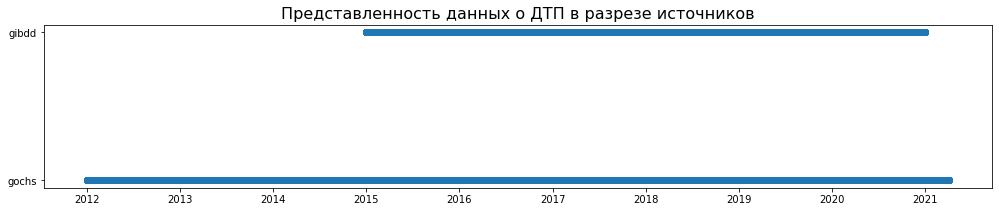

In [101]:
fig, ax = plt.subplots(figsize=(17,3))
plt.scatter(road_9['datetime'], road_9['data_source'])
ax.set_title('Представленность данных о ДТП в разрезе источников',loc='center', fontsize=16)
plt.show()

Для дальнейшего обучения модели **выберем данные о ДТП по всем трассам**. Рассмотрим ситуацию для всех значений переменной `target`. Выберем период наблюдения с 2016-01-01 по 2020-12-31, заполним промежутки между наблюдениями на всем временном интервале нулевыми значениями с шагом в один час, присвоив значения 0 (событие не является ДТП) переменной `target`, и обогатим исходную выборку переменными из других датасетов.

In [163]:
START_TRAIN_DATE = '2016-01-01'
END_TRAIN_DATE = '2020-12-31'

def filter_by_dates(df, start_date, train_date, datetime_col = 'datetime'):
    date_condition1 = (df[datetime_col] >= start_date)
    date_condition2 = (df[datetime_col] <= train_date)
    return df[date_condition1 & date_condition2]

In [164]:
df = filter_by_dates(df, START_TRAIN_DATE, END_TRAIN_DATE)
#df = df[['datetime','road_km','target']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86632 entries, 22740 to 109371
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         86632 non-null  datetime64[ns]
 1   road_id          86632 non-null  int64         
 2   road_km          86632 non-null  int64         
 3   man_injured_num  86632 non-null  int64         
 4   man_dead_num     86632 non-null  int64         
 5   car_damaged_num  86632 non-null  float64       
 6   road_name        86632 non-null  object        
 7   lon              47570 non-null  float64       
 8   lat              47570 non-null  float64       
 9   data_source      86632 non-null  object        
 10  target           86632 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 7.9+ MB


In [165]:
df.target.value_counts()

1    72491
2    14114
3       27
Name: target, dtype: int64

Как видно, данные не сбалансированны по классам

#### Обагащение выборки переменными из остальных датасетов

In [127]:
traffic = pd.read_pickle('data/traffic.pickle')
repair = pd.read_pickle('data/repair.pickle')
crash_parts = pd.read_pickle('data/crash_parts.pickle')
atmos = pd.read_pickle('data/atmos.pickle')
geo_data = pd.read_pickle('data/geo_data.pickle')
meteo = pd.read_pickle('data/meteo.pickle')
tele2_data = pd.read_pickle('data/tele2_data.pickle')

In [258]:
r21_attributes = pd.read_pickle('data/Р-21-атрибуты.pickle')

### TODO: исследовать Р21 аттрибуты

In [259]:
r21_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209385 entries, 0 to 209384
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 209385 non-null  int64  
 1   way_id                  209385 non-null  int64  
 2   way_version             209385 non-null  int64  
 3   way_status              209385 non-null  object 
 4   point_status            209385 non-null  object 
 5   processed_date          209385 non-null  object 
 6   way_sort_order          209385 non-null  int64  
 7   point_sort_order        209385 non-null  int64  
 8   lat                     209385 non-null  int64  
 9   lon                     209385 non-null  int64  
 10  direction               209385 non-null  bool   
 11  photo_name              0 non-null       float64
 12  photo_date              209125 non-null  object 
 13  vehicle_occupant_score  209385 non-null  float64
 14  motorcyclist_score  

In [260]:
r21_attributes.head()

,user_id,way_id,way_version,way_status,point_status,processed_date,way_sort_order,point_sort_order,lat,lon,direction,photo_name,photo_date,vehicle_occupant_score,motorcyclist_score,bicyclist_score,pedestrian_score,item_code,item_name,user_attribute_number,user_attribute_name,ml_attribute_number,ml_attribute_name,osm_attribute_number,osm_attribute_name,OSM_tags
0,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,13,Carriageway label,3,Undivided road,NaN,NaN,NaN,NaN,NaN
1,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,20,Land use - driver-side,1,Undeveloped areas,NaN,NaN,NaN,NaN,NaN
2,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,21,Land use – passenger-side,1,Undeveloped areas,NaN,NaN,NaN,NaN,NaN
3,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,22,Area type,1,Rural,NaN,NaN,NaN,NaN,NaN
4,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,23,Speed limit,13,90km/h,NaN,NaN,NaN,NaN,NaN


### TODO: исследовать traffic.csv - Дима Д

In [157]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275667 entries, 2697651 to 7141751
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   datetime    1275667 non-null  datetime64[ns]
 1   road_id     1275667 non-null  int64         
 2   road_km     1275667 non-null  int64         
 3   name        1275667 non-null  object        
 4   data_id     1275667 non-null  int64         
 5   station_id  1275667 non-null  int64         
 6   lane        1275667 non-null  int64         
 7   lane_count  1275667 non-null  int64         
 8   direction   1275667 non-null  object        
 9   volume      1275667 non-null  float64       
 10  occupancy   1275667 non-null  float64       
 11  speed       1275667 non-null  float64       
 12  latitude    1275667 non-null  float64       
 13  longitude   1275667 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(2)
memory usage: 146.0+ M

In [158]:
traffic.head()

,datetime,road_id,road_km,name,data_id,station_id,lane,lane_count,direction,volume,occupancy,speed,latitude,longitude
2697651,2020-01-01 01:00:00,9,578,км 578+300,34619378,41106,1,2,backward,20.0,0.66,54.0,60.000762,41.072852
2697652,2020-01-01 01:00:00,9,977,км 977+500,34619557,41115,1,1,backward,20.0,1.00,96.0,62.952595,42.587645
2697653,2020-01-01 01:00:00,9,578,км 578+300,34619378,41106,2,2,backward,18.0,0.59,60.0,60.000762,41.072852
2697654,2020-01-01 01:00:00,9,578,км 578+300,34619378,41106,1,2,forward,10.0,0.26,34.0,60.000762,41.072852
2697655,2020-01-01 01:00:00,9,977,км 977+500,34619557,41115,1,1,forward,24.0,1.20,96.0,62.952595,42.587645


In [161]:
traffic = filter_by_dates(traffic, START_TRAIN_DATE, END_TRAIN_DATE)

In [162]:
traffic.road_id.value_counts()

9     687181
14    588486
Name: road_id, dtype: int64

Отсутствуют данные по траффику на дороге 5

In [170]:
traffic.drop_duplicates(inplace = True)

In [172]:
traffic.lane.value_counts()

1    912019
2    304995
3     42714
4      5314
6      5313
5      5312
Name: lane, dtype: int64

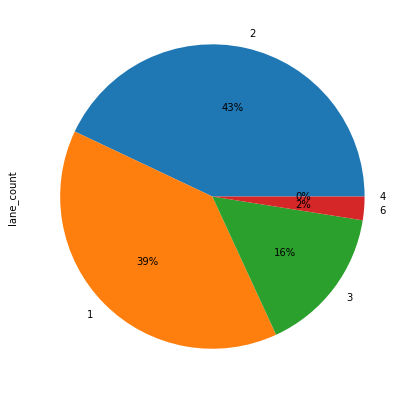

In [174]:
traffic.lane_count.value_counts().plot(kind = 'pie', figsize = (7, 7), autopct='%1.0f%%');

In [175]:
traffic.direction.value_counts()

backward    647450
forward     628217
Name: direction, dtype: int64

<AxesSubplot:>

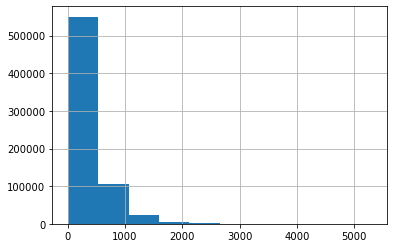

In [178]:
traffic.loc[traffic.road_id == 9].volume.hist()

<AxesSubplot:>

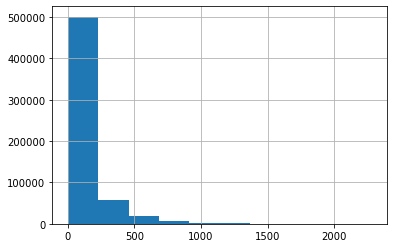

In [179]:
traffic.loc[traffic.road_id == 14].volume.hist()

<AxesSubplot:>

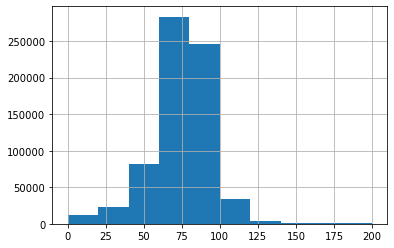

In [180]:
traffic.loc[traffic.road_id == 9].speed.hist()

<AxesSubplot:>

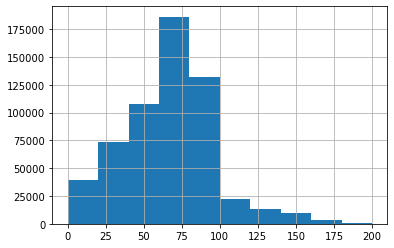

In [182]:
traffic.loc[traffic.road_id == 14].speed.hist()

### Анализ данных об аварийных участках (crash_parts) - Дима Д

In [183]:
crash_parts = filter_by_dates(crash_parts, START_TRAIN_DATE, END_TRAIN_DATE)

In [184]:
crash_parts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 166
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       164 non-null    int64         
 1   datetime         164 non-null    datetime64[ns]
 2   road_id          164 non-null    int64         
 3   road_km          164 non-null    int64         
 4   avuch_start      164 non-null    float64       
 5   avuch_end        164 non-null    float64       
 6   length           164 non-null    int64         
 7   avuch_loc        164 non-null    int64         
 8   stabchar_type    164 non-null    int64         
 9   planactiv_type   164 non-null    int64         
 10  planactiv_descr  164 non-null    object        
 11  planactiv_year   164 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(7), object(1)
memory usage: 16.7+ KB


In [185]:
crash_parts.head()

,Unnamed: 0,datetime,road_id,road_km,avuch_start,avuch_end,length,avuch_loc,stabchar_type,planactiv_type,planactiv_descr,planactiv_year
0,0,2017-01-01,9,124,124.77,125.74,970,2,3,4,Дублирование дорожных знаков 3.20 «Обгон запрещен» на щитах с флуорисцентной пленкой желто-зеленого цвета. Щит аварийно-опасный участок.,2018-07-01
1,1,2017-01-01,9,125,124.77,125.74,970,2,3,4,Дублирование дорожных знаков 3.20 «Обгон запрещен» на щитах с флуорисцентной пленкой желто-зеленого цвета. Щит аварийно-опасный участок.,2018-07-01
2,2,2017-01-01,9,131,131.88,132.77,890,2,3,4,"Щит аварийно-опасный участок. В 2018 году будет проводиться мониторинг состояния аварийности, разработка и реализация дополнительных мероприятий по БДД, будет выполнена по мере необходимости;",2018-03-01
3,3,2017-01-01,9,132,131.88,132.77,890,2,3,4,"Щит аварийно-опасный участок. В 2018 году будет проводиться мониторинг состояния аварийности, разработка и реализация дополнительных мероприятий по БДД, будет выполнена по мере необходимости;",2018-03-01
4,4,2017-01-01,9,145,145.10,145.80,700,2,1,4,"Установлен щит «Аварийно-опасный участок». Изменение режима работы светофорного объекта, проработать вопрос устройства искусственного освещения на перекрестке.",2018-09-01


In [186]:
crash_parts.planactiv_descr.value_counts()

1. Установить щиты аварийно-опасный участок.\n2. Установка стационарного комплекса автоматической фиксации нарушений ПДД.\n3. Рассмотреть вопрос устройства шумовых полос.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [187]:
len(crash_parts.planactiv_descr.value_counts())

107

In [195]:
crash_parts.road_id.value_counts()

9     147
14     17
Name: road_id, dtype: int64

In [188]:
crash_parts.datetime.value_counts()

2017-01-01    41
2020-01-01    36
2018-01-01    32
2019-01-01    29
2016-01-01    26
Name: datetime, dtype: int64

In [190]:
crash_parts.stabchar_type.value_counts()

3    114
1     30
2     20
Name: stabchar_type, dtype: int64

характеристика стабильности местоположения участка концентрации ДТП. Принимает следующие 3 значения:
• 1 - Стабильный;
• 2 - Мигрирующий (подразумевается варьирующий характер частоты ДТП на
данном участке при сравнении по годам);
• 3 - Вновь возникший (подразумевает возникновение нескольких аварийно опасных
ситуаций в рамках одного года).

In [193]:
crash_parts.planactiv_type.value_counts()

4    141
2     19
1      4
Name: planactiv_type, dtype: int64

код планируемого/планируемых работ на данном участке. Принимает следующие 4 значения:
• 1 - реконструкция;
• 2 - капитальный ремонт;
• 3 - ремонт;
• 4 - содержание.

#### TODO: Важная фича - произошло ли событие на аварийном участке.

In [196]:
df.head()

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target
22740,2016-01-01 04:00:00,5,5,0,0,1.0,М-4 (E115) =Дон= Москва - Новороссийск,NaN,NaN,gibdd,1
22741,2016-01-01 06:00:00,9,23,0,0,1.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",NaN,NaN,gibdd,1
22742,2016-01-01 07:00:00,5,199,0,0,2.0,М-4 (E115) =Дон= Москва - Новороссийск,NaN,NaN,gibdd,1
22743,2016-01-01 08:00:00,14,76,0,0,2.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,NaN,NaN,gibdd,1
22744,2016-01-01 08:00:00,5,174,0,0,2.0,М-4 (E115) =Дон= Москва - Новороссийск,NaN,NaN,gibdd,1


In [250]:
def is_on_crash_part(row):
    road_id = row['road_id']  
    if road_id != 5:
        road_crash_parts = crash_parts.loc[crash_parts['road_id'] == road_id]
        for index, crash_part in road_crash_parts.iterrows():
            if crash_part['road_km'] <= row['road_km'] <= round(crash_part['avuch_end']):
                return True
        
    return False

In [251]:
df['on_crash_part'] = df.apply(lambda row: is_on_crash_part(row), axis = 1)

In [252]:
df.head()

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target,on_crash_part
22740,2016-01-01 04:00:00,5,5,0,0,1.0,М-4 (E115) =Дон= Москва - Новороссийск,NaN,NaN,gibdd,1,False
22741,2016-01-01 06:00:00,9,23,0,0,1.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",NaN,NaN,gibdd,1,True
22742,2016-01-01 07:00:00,5,199,0,0,2.0,М-4 (E115) =Дон= Москва - Новороссийск,NaN,NaN,gibdd,1,False
22743,2016-01-01 08:00:00,14,76,0,0,2.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,NaN,NaN,gibdd,1,False
22744,2016-01-01 08:00:00,5,174,0,0,2.0,М-4 (E115) =Дон= Москва - Новороссийск,NaN,NaN,gibdd,1,False


In [253]:
df.on_crash_part.value_counts()

False    77083
True      9549
Name: on_crash_part, dtype: int64

In [254]:
df.loc[df.road_id != 5].on_crash_part.value_counts()

False    27053
True      9549
Name: on_crash_part, dtype: int64

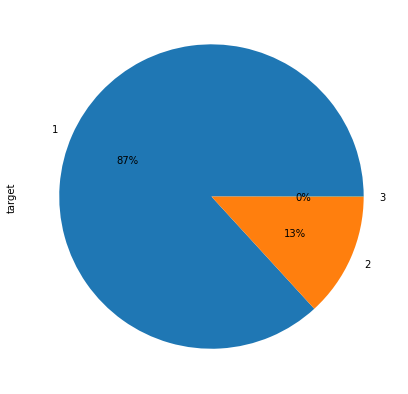

In [255]:
df.loc[df.on_crash_part == True].target.value_counts().plot(kind = 'pie', figsize = (7, 7), autopct='%1.0f%%');

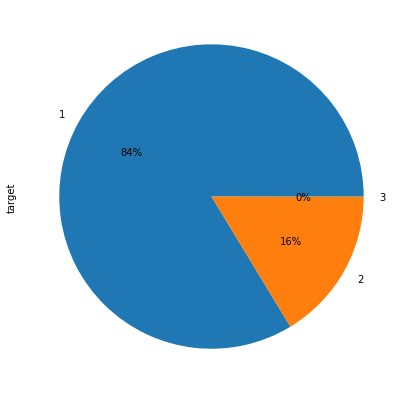

In [256]:
df.target.value_counts().plot(kind = 'pie', figsize = (7, 7), autopct='%1.0f%%');

### TODO: Анализ geo_data - ?

### TODO: Анализ данных о погоде (Леша)

In [134]:
# фильтр датасетов по заданным уловиям
condition1 = (repair['datetime'] == START_TRAIN_DATE) | (repair['datetime'] == END_TRAIN_DATE)
repair = repair[condition1]

condition2 = (traffic['datetime'] > '2020-01-01')
condition3 = (traffic['datetime'] < '2020-12-31')
traffic = traffic[condition2 & condition3]

In [135]:
def hour_rounder(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [136]:
# округление переменной datetime до часа
traffic['datetime'] = traffic['datetime'].map(lambda x: hour_rounder(x))

In [137]:
# объединение датасета с данными о ДТП с данными о трафике
tmp = pd.merge(df, traffic, how='outer', on=['datetime', 'road_km'])
condition1 = (tmp['target'].isnull()) & (tmp['data_id'].isnull())
condition2 = ~(tmp['target'].isnull()) & (tmp['data_id'].isnull())
tmp = tmp.drop(tmp[condition1].index)
tmp = tmp.drop(tmp[condition2].index)
tmp = tmp.fillna(0)
tmp.head(2)

,datetime,road_id_x,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target,road_id_y,name,data_id,station_id,lane,lane_count,direction,volume,occupancy,speed,latitude,longitude
76172,2020-01-04 17:00:00,5.0,856,0.0,0.0,1.0,М-4 (E115) =Дон= Москва - Новороссийск,40.4603,48.9408,gibdd,1.0,14.0,км 855+800,34683992.0,1102.0,1.0,1.0,backward,33.0,0.757812,76.6275,64.915595,34.248307
76173,2020-01-04 17:00:00,5.0,856,0.0,0.0,1.0,М-4 (E115) =Дон= Москва - Новороссийск,40.4603,48.9408,gibdd,1.0,14.0,км 855+800,34683992.0,1102.0,1.0,1.0,forward,42.0,1.960938,62.0650,64.915595,34.248307


In [138]:
# добавление данных о ремонте дороги на указанном километре
tmp['year'] = tmp['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)
index_repair = tmp[tmp.set_index(['road_km','year']).index.isin(repair.set_index(['road_km','year']).index)].index
tmp.loc[index_repair, 'repair'] = 1
tmp = tmp.fillna(0)
tmp.head(2)

,datetime,road_id_x,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target,road_id_y,name,data_id,station_id,lane,lane_count,direction,volume,occupancy,speed,latitude,longitude,year,repair
76172,2020-01-04 17:00:00,5.0,856,0.0,0.0,1.0,М-4 (E115) =Дон= Москва - Новороссийск,40.4603,48.9408,gibdd,1.0,14.0,км 855+800,34683992.0,1102.0,1.0,1.0,backward,33.0,0.757812,76.6275,64.915595,34.248307,2020,0.0
76173,2020-01-04 17:00:00,5.0,856,0.0,0.0,1.0,М-4 (E115) =Дон= Москва - Новороссийск,40.4603,48.9408,gibdd,1.0,14.0,км 855+800,34683992.0,1102.0,1.0,1.0,forward,42.0,1.960938,62.0650,64.915595,34.248307,2020,0.0


In [139]:
# выбор переменных
columns = ['datetime',
           'road_km',
           'target',
           'volume',
           'occupancy',
           'speed',
           'repair']
tmp = tmp[columns]
tmp.reset_index(drop=True, inplace=True)
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275667 entries, 0 to 1275666
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   datetime   1275667 non-null  datetime64[ns]
 1   road_km    1275667 non-null  int64         
 2   target     1275667 non-null  float64       
 3   volume     1275667 non-null  float64       
 4   occupancy  1275667 non-null  float64       
 5   speed      1275667 non-null  float64       
 6   repair     1275667 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.1 MB


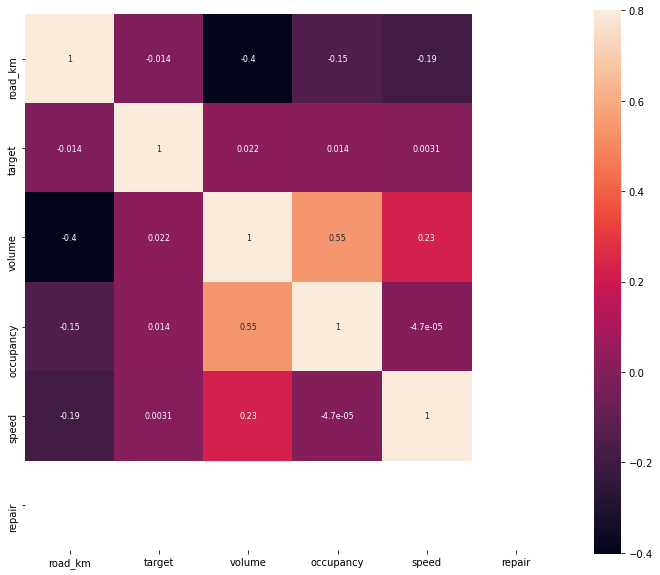

In [140]:
corrmat = tmp.corr()
f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,annot_kws={'size':8})
plt.show()

### 2. Формирование модели. Обучение. Тестирование.

In [141]:
print("Нулевых значений переменной target: ", tmp[tmp['target'] == 0].shape[0])
print("Ненулевых значений переменной target: ", tmp[tmp['target'] != 0].shape[0])

Нулевых значений переменной target:  1274512
Ненулевых значений переменной target:  1155


In [142]:
# снизим объем выборки, рандомно удалив 98% строк с нулевыми значениями для target
tmp = tmp.drop(tmp[tmp['target'] == 0].sample(frac=.98).index)

In [143]:
tmp_train, tmp_test = train_test_split(tmp, test_size=0.2)
print("Размер выборки для обучения: ", tmp_train.shape)
print("Размер выборки для тестирования: ", tmp_test.shape)

Размер выборки для обучения:  (21316, 7)
Размер выборки для тестирования:  (5329, 7)


Выделим 20% всех данных на тестирование, остальные оставим на обучение

In [144]:
%%time
columns = ['volume',
           'occupancy',
           'speed',
           'repair']
tmp_train_x = tmp_train[columns]
tmp_train_y = tmp_train['target']

tmp_test_x = tmp_test[columns]
tmp_test_y = tmp_test['target']

clf = svm.SVC(gamma='auto', probability=True)
clf.fit(tmp_train_x, tmp_train_y)
predicted_target = clf.predict(tmp_test_x)

CPU times: user 4min 3s, sys: 2.81 s, total: 4min 6s
Wall time: 4min 6s


In [145]:
# оценим модель на тестово сэмпле
f1_score(tmp_test_y, predicted_target, average='macro')

0.32873536401338227

### 3. Проверка на основной тестовой выборке (предсказание)

In [147]:
# загрузка выборки
test = pd.read_pickle('data/test.pickle')
# выбор трассы М-8
#test = test[test["road_id"]==9]

#### Обагащение выборки переменными из датасетов `traffic.csv`, `repair.csv`

In [148]:
# объединение выборки с данными о трафике
test = pd.merge(test, traffic, how='outer', on=['datetime', 'road_km','road_id'])
condition1 = (test['target'].isnull()) & (test['data_id'].isnull())
test = test.drop(test[condition1].index)
test.head(2)

,datetime,road_id,road_km,target,name,data_id,station_id,lane,lane_count,direction,volume,occupancy,speed,latitude,longitude
38,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,3.0,3.0,forward,87.0,1.0,114.671875,56.041809,37.892898
39,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,2.0,3.0,forward,207.0,1.0,115.708435,56.041809,37.892898


In [149]:
# добавление данных о ремонте дороги на указанном километре
test['year'] = test['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)

In [150]:
index_repair = test[test.set_index(['road_km','year']).index.isin(repair.set_index(['road_km','year']).index)].index
test.loc[index_repair, 'repair'] = 1
test['repair'] = test['repair'].fillna(0)
test.head()

,datetime,road_id,road_km,target,name,data_id,station_id,lane,lane_count,direction,volume,occupancy,speed,latitude,longitude,year,repair
38,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,3.0,3.0,forward,87.0,1.0,114.671875,56.041809,37.892898,2020,0.0
39,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,2.0,3.0,forward,207.0,1.0,115.708435,56.041809,37.892898,2020,0.0
40,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,1.0,3.0,forward,43.0,20.0,46.453125,56.041809,37.892898,2020,0.0
41,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,2.0,3.0,backward,195.0,1.0,97.796875,56.041809,37.892898,2020,0.0
42,2020-01-01 01:00:00,9,38,NaN,км 38+300,34604682.0,53224.0,3.0,3.0,backward,89.0,1.0,108.213440,56.041809,37.892898,2020,0.0


In [151]:
print("Размер выборки для тестирования: ", test.shape)

Размер выборки для тестирования:  (1275667, 17)


In [152]:
# выбор переменных
columns = ['volume',
           'occupancy',
           'speed',
           'repair']

#### Предсказание и оценка модели

In [153]:
%%time
# предсказание значений переменной target
test['target'] =  clf.predict(test[columns])

CPU times: user 27min 5s, sys: 4.86 s, total: 27min 10s
Wall time: 27min 15s


In [154]:
prediction = test[['datetime','road_id','road_km','target']]
prediction.to_csv('prediction.csv', index=False)

In [45]:
# загрузка реальных данных тестовой выборки
test_secret = pd.read_csv('data/test_secret.pickle', parse_dates=['datetime'])
# выбор трассы М-8
test_secret = test_secret[test_secret["road_id"]==9]

In [46]:
check = pd.merge(prediction, test_secret, how='left', on=['datetime', 'road_km','road_id'])
# сформируем выборку предсказанных занчений
check = check.drop(check[check['target_y'].isnull()].index)

In [47]:
check.head()

,datetime,road_id,road_km,target_x,target_y


In [48]:
print("Кол-во предсказанных значений: ", check['target_x'].shape[0])
print("Кол-во фактических значений: ", check['target_y'].shape[0])

Кол-во предсказанных значений:  0
Кол-во фактических значений:  0


In [49]:
# оценка модели на реальных данных тестовой выборки 
f1_score(check['target_y'], check['target_x'], average='macro')

/Users/dmitriy.donchenko/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/dmitriy.donchenko/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan